This model uses as features: 
* Customer demographics removing Comuna and Profesion, (customer_feat)
* Old count history, previous 13 th month (old_history_feat) 
* Last 13 months count history (current_history_feat)
* This model balanced classes using the is_balanced parameter of lightgbm

# Notebook Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install ml-metrics

  Created wheel for ml-metrics: filename=ml_metrics-0.1.4-cp36-none-any.whl size=7850 sha256=fb89ab1cc4717986cbce14a6d63134becaddcf9bb021e75fe152c5f3d27cce20
  Stored in directory: /root/.cache/pip/wheels/b3/61/2d/776be7b8a4f14c5db48c8e5451451cabc58dc6aa7ee3801163
Successfully built ml-metrics


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cd /content/drive/MyDrive/itau/

/content/drive/MyDrive/itau


# Preparing Data

In [5]:
import pandas as pd
import numpy as np
from dataset.dataset import Dataset

In [6]:
ds = Dataset()
ds.load_data()

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [191]:

def get_features(train=True):
    counts = ds.get_transactions_counts()
    # Customer features
    customer_feat = pd.get_dummies(ds.customers_df.set_index("id").drop(columns=['Comuna','Profesion']))
    # Transactions features
    input_counts = counts.iloc[:,:-3].copy() if train else counts.copy() #-3 is because these are in the training features
    old_history_feat = pd.DataFrame((input_counts.iloc[:,:-13].sum(axis=1)>0).astype('float'),columns=['old_count']).unstack().fillna(0)
    current_history_feat = input_counts.iloc[:,-13:].unstack().fillna(0)
    # Full features
    features = np.hstack([old_history_feat, current_history_feat, customer_feat])
    #features = np.hstack([old_history_feat, current_history_feat])
    return features

In [192]:
# Features
train_features = get_features(train=True)
test_features = get_features(train=False)
# Labels
labels = (counts.iloc[:,-3:].sum(axis=1))
labels = labels.unstack(-1) > 0
actuals = [list(np.array(labels.columns)[x]) for x in labels.values]
labels = labels.astype(int)

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_features, labels, random_state=42)

In [18]:
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
resampled_datasets = [] 

ros = RandomOverSampler(random_state=0)
resampled_datasets.append(ros.fit_resample(X_train, y_train.iloc[:,i]))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [11]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score

In [12]:
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt

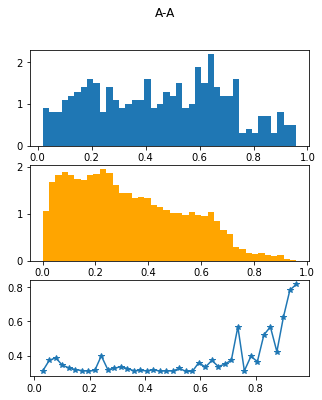

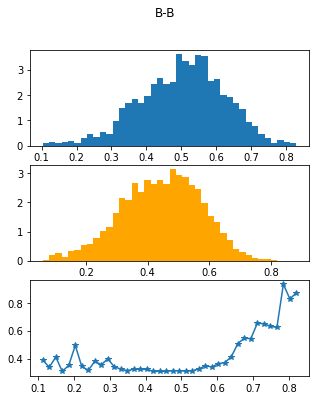

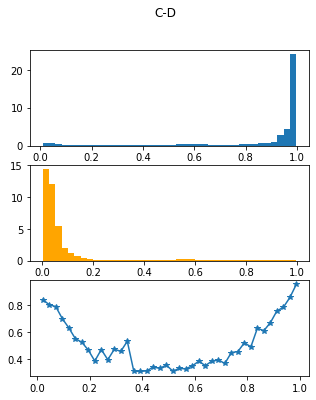

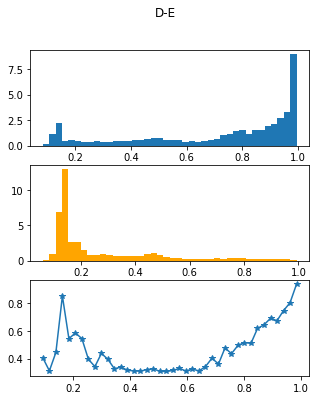

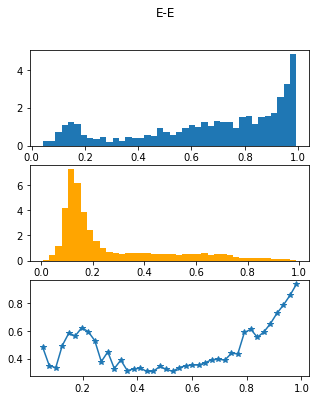

In [13]:
eps = 1e-7
models = []
certainties = []

for prod_index in range(5):
    lgbm_unb = LGBMClassifier(is_unbalance=True).fit(X_train, y_train.iloc[:,prod_index])
    models.append(lgbm_unb)

    # Plotting 
    f, ax = plt.subplots(3,1,figsize=(5,6))
    plt.suptitle(f'{ds.PRODUCTS[prod_index]}')
    clf = lgbm_unb
    plt.sca(ax[0])
    a = plt.hist(clf.predict_proba(X_test)[(y_test.iloc[:,prod_index]==1).values,1], bins=40, density=True)
    plt.sca(ax[1])
    b = plt.hist(clf.predict_proba(X_test)[(y_test.iloc[:,prod_index]==0).values,1], color='orange', bins=40, density=True)
    plt.sca(ax[2])
    pb = b[0]/(b[0]+a[0]+eps)
    pa = a[0]/(b[0]+a[0]+eps)
    H = -(pb*np.log(pb+eps) + pa*np.log(pa + eps))
    C = 1 - H
    x = 0.5*a[1][1:]+0.5*a[1][:-1]
    certainties.append((x,C))
    plt.plot(x, C, '-*')
    plt.show()

In [14]:
def interpolate(x, certainty, ts):
    """
    x: x values for certainty values
    t: point to interpolate certainty
    """
    ys = []
    for t in ts:
        y = certainty[0] if t <= x[0] else certainty[-1]
        for i in range(len(x)-1):
            if (t >= x[i]) & (t<=x[i+1]):
                alpha = (x[i+1] - t)/(x[i+1] - x[i])
                y = (alpha) * certainty[i] + (1-alpha) * certainty[i+1]
                break
        ys.append(y)
    ys = np.array(ys)
    return ys

In [49]:
def rank_score(prob, certainty, w1=1, e1=1, w2=0, e2=0, w3=0, e3=0):
    rank_score = w1 * prob * (certainty ** e1) + w2 * prob * (1-certainty**e2) + w3 * (1-prob) * (1-certainty**e3)
    return rank_score
rank_score(np.array([0.8,0,0.6,1]), np.array([0.6,0.1,1,0.4]))

array([0.48, 0.  , 0.6 , 0.  ])

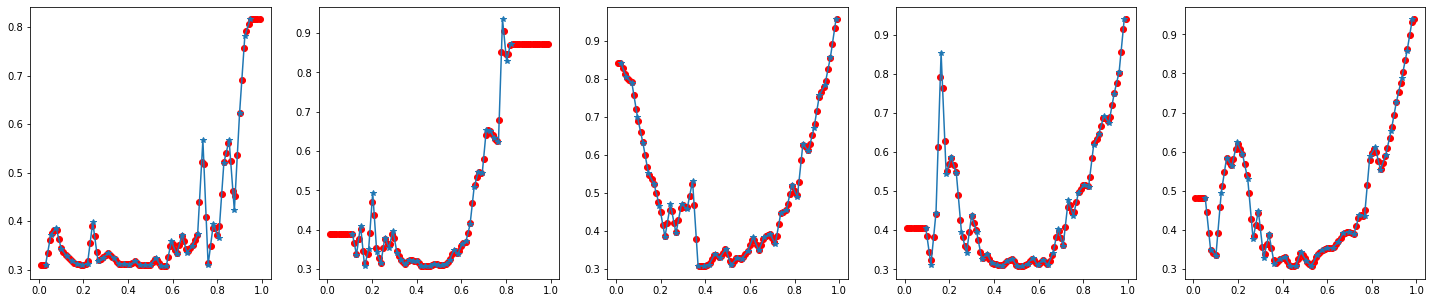

In [33]:
f, ax = plt.subplots(1,5,figsize=(25,5))
for i,ax in enumerate(ax):
    x, certainty = certainties[i]
    ts = np.arange(0.01,1,0.01)
    ys = interpolate(x, certainty, ts=ts)
    plt.sca(ax)
    plt.plot(ts,ys,'ro')
    plt.plot(x,certainty,'*-')

## Inference

In [186]:
eps = 1e-7
models = []

for prod_index in range(5):
    lgbm_unb = LGBMClassifier(is_unbalance=True).fit(train_features, labels.iloc[:,prod_index])
    models.append(lgbm_unb)

In [187]:
rank_scores = []
preds = []
for i, model in enumerate(models):
    pred = model.predict_proba(test_features)[:,1]
    x, certainty = certainties[i]
    certs = interpolate(x, certainty, ts=pred)
    preds.append(pred)
    rank_scores.append(rank_score(pred, certs))
rank_scores = np.array(rank_scores).transpose()

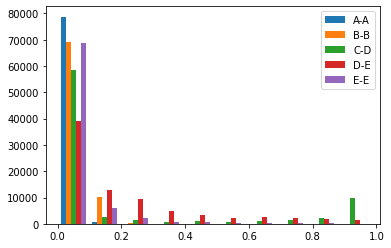

In [188]:
plt.hist(rank_scores);
plt.legend(ds.PRODUCTS)

In [189]:
from utils import from_preds_to_products
product_preds = from_preds_to_products(rank_scores)

In [190]:
entrega_df = pd.read_csv(ds.BASE_DATA_PATH / 'ejemplo_entregaVF.csv', index_col='id')
entrega_df['productos'] = [" ".join(x) for x in product_preds]
from datetime import datetime
filename = ds.BASE_PATH/f'predictions/{datetime.now().strftime("%Y-%m-%d_%H:%M:%S")}.csv'
entrega_df.to_csv(filename)


## Checking the performance

In [ ]:
train_preds_ = []
test_preds_ = []
for prod_index in range(5):
    model = LGBMClassifier(is_unbalance=True).fit(X_train, y_train.iloc[:,prod_index])
    pred = model.predict_proba(X_train)[:,1]
    train_preds_.append(pred)
    pred = model.predict_proba(X_test)[:,1]
    test_preds_.append(pred)

In [167]:
print(f"Perfect mAP: {mAP(y_true=y_train.values, y_pred=y_train.values)}")
train_preds = []
test_preds = []

for prod_index in range(5):
    x, certainty = certainties[prod_index]
    pred = train_preds_[prod_index]
    certs = interpolate(x, certainty, ts=pred)
    train_preds.append(rank_score(pred, certs))

    pred = test_preds_[prod_index]
    certs = interpolate(x, certainty, ts=pred)
    test_preds.append(rank_score(pred, certs))
    
train_preds = np.array(train_preds).transpose()
test_preds = np.array(test_preds).transpose()

from sklearn.model_selection import train_test_split
from utils import mAP
#X_train, X_test, y_train, y_test = train_test_split(train_features, labels)

print(f"Train mAP: {mAP(y_true=y_train.values, y_pred=train_preds)}")
print(f"Test mAP: {mAP(y_true=y_test.values, y_pred=test_preds)}")

Perfect mAP: 0.5268213363730848
Train mAP: 0.4630210603368313
Test mAP: 0.445944388567597


## Checking importances

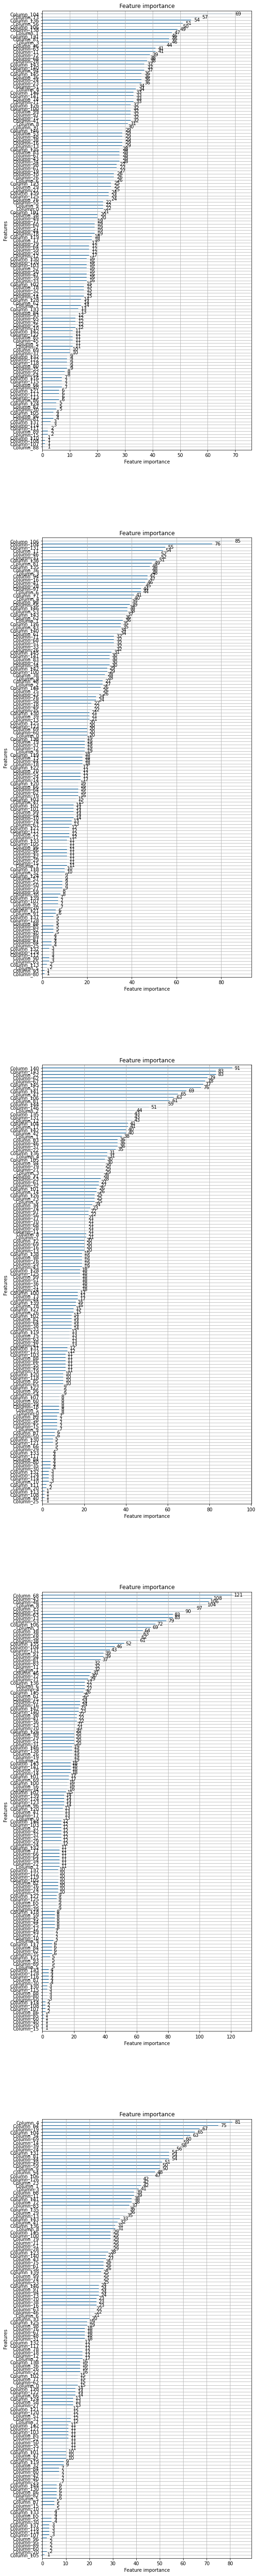

In [169]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
f, axs = plt.subplots(5,1, figsize=(8,100))
for i, ax in enumerate(axs): 
    plot_importance(models[i], ax=ax)

# Submission

In [ ]:
model = MultiOutputClassifier(LGBMClassifier())
model.set_params(**grid_search.best_params_)
model.fit(train_features, labels)

MultiOutputClassifier(estimator=LGBMClassifier(boosting_type='gbdt',
                                               class_weight=None,
                                               colsample_bytree=1.0,
                                               importance_type='split',
                                               learning_rate=0.1, max_depth=-1,
                                               min_child_samples=20,
                                               min_child_weight=0.001,
                                               min_split_gain=0.0,
                                               n_estimators=50, n_jobs=-1,
                                               num_leaves=31, objective=None,
                                               random_state=None, reg_alpha=0.0,
                                               reg_lambda=0.0, silent=True,
                                               subsample=1.0,
                                               subsample_for_bin=

In [ ]:
from utils import from_preds_to_products
preds = model.predict_proba(test_features)

In [ ]:
product_preds = from_preds_to_products(preds)

In [ ]:
entrega_df = pd.read_csv(ds.BASE_DATA_PATH / 'ejemplo_entregaVF.csv', index_col='id')
entrega_df['productos'] = [" ".join(x) for x in product_preds]
from datetime import datetime
filename = ds.BASE_PATH/f'predictions/{datetime.now().strftime("%Y-%m-%d_%H:%M:%S")}.csv'
entrega_df.to_csv(filename)